# 2-D Image Processing

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage
from skimage import filters, io, morphology, measure, img_as_float, img_as_uint
from scipy.ndimage import median_filter
import seaborn as sns
sns.set(font_scale=1.5)

In [3]:
def plot_image(img, figsize=(11,8), cmap='gray', xticklabels=50, yticklabels=50, title='', **kwargs):
    if 'ax' not in kwargs:
        plt.figure(figsize=figsize)
    ax = sns.heatmap(img, cmap=cmap, xticklabels=xticklabels, yticklabels=yticklabels, 
                cbar_kws={'label':'Pixel Intensity'}, **kwargs);
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    if title:
        ax.set_title(title)

## Numismatism

In [4]:
coins_raw = skimage.data.coins().astype('float') # Load the coins image, convert from integers to floats
coins_raw.shape # How big is it (pixels wide by pixels tall)?

(303, 384)

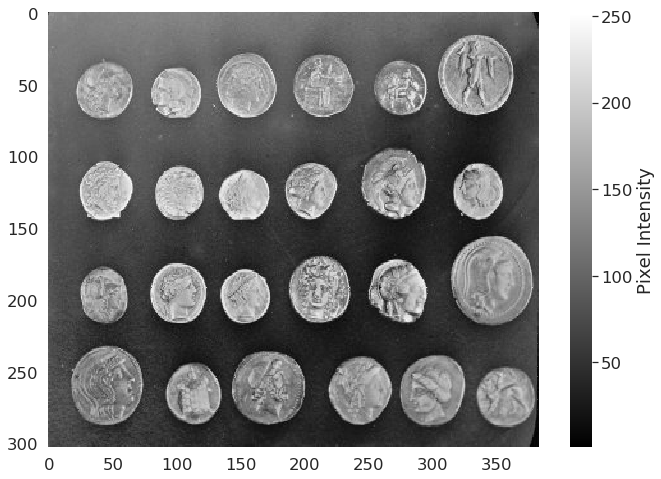

In [5]:
plot_image(coins_raw)

## How are images represented?

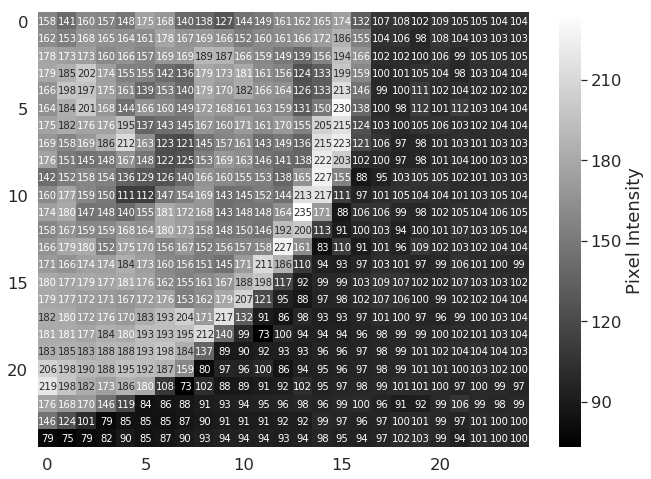

In [6]:
plot_image(coins_raw[50:75, 50:75], xticklabels=5, yticklabels=5, annot=True, fmt=".0f");

## Can we smooth the image to make it look better?

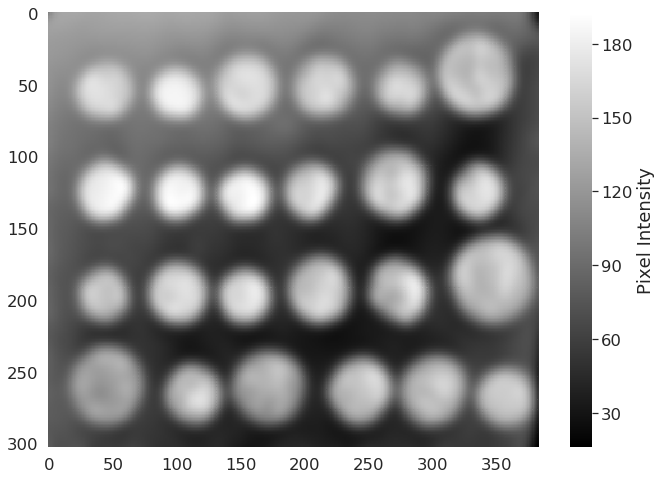

In [7]:
smoothing_radius = 5
coins_smooth = skimage.filters.gaussian(coins_raw, smoothing_radius)
plot_image(coins_smooth);

### Many kinds of smoothing smear the signal along with the noise!

## Background subtraction with dilation

In [8]:
seed = coins_raw.copy()
seed[1:-1, 1:-1] = coins_raw.min()

coins_dilated = morphology.reconstruction(seed, coins_raw, method='dilation')

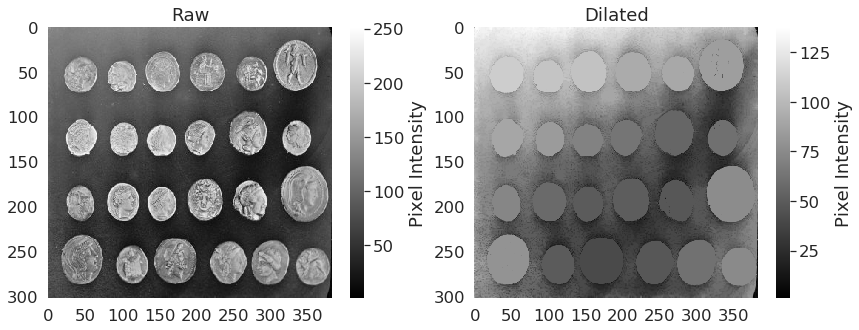

In [9]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
plot_image(coins_raw, title='Raw', ax=ax[0])
plot_image(coins_dilated, title='Dilated', ax=ax[1])

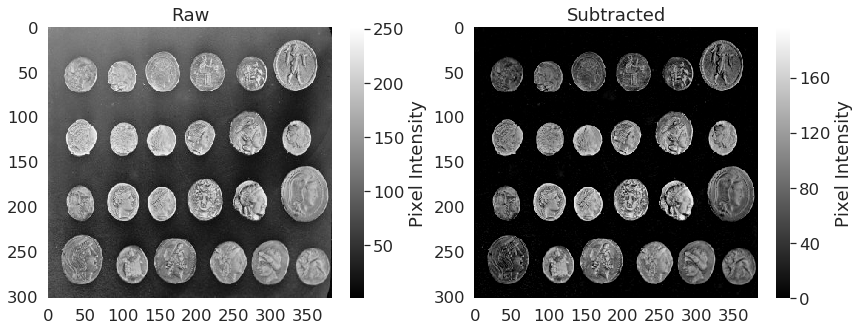

In [11]:
coins_clean = coins_raw - coins_dilated
fig, ax = plt.subplots(1,2, figsize=(14,5))
plot_image(coins_raw, title='Raw', ax=ax[0])
plot_image(coins_clean, title='Subtracted', ax=ax[1])

## Using edge detection to distinguish objects from background

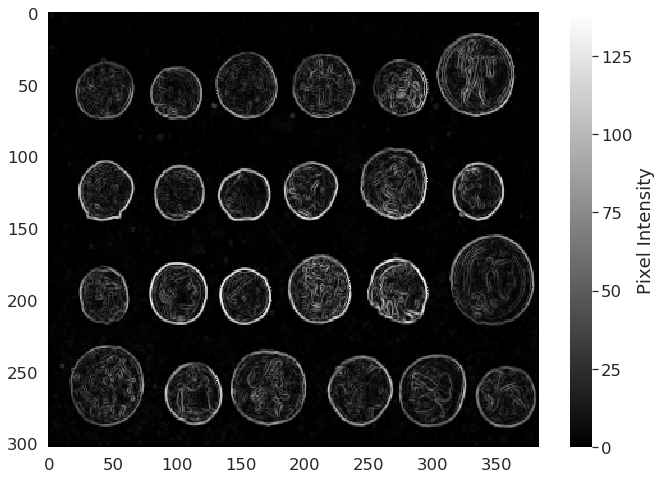

In [14]:
coins_edges = filters.sobel(coins_clean) 
# The sobel filter (works like your own visual system!)
plot_image(coins_edges);

## Identifying edge contours systematically

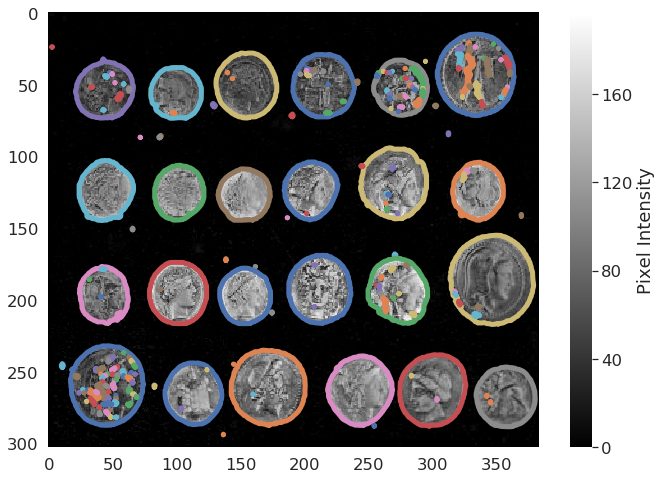

In [11]:
# Find contours that distinguish values below `threshold` from values above `threshold`
threshold = 20
contours = measure.find_contours(coins_clean, threshold)

# Show the image
plot_image(coins_clean)

# Show all contours found (one color for each contour)
for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=5)

## Smoothing revisited (median filtering)

In [12]:
coins_cleaner = median_filter(coins_clean, 9)

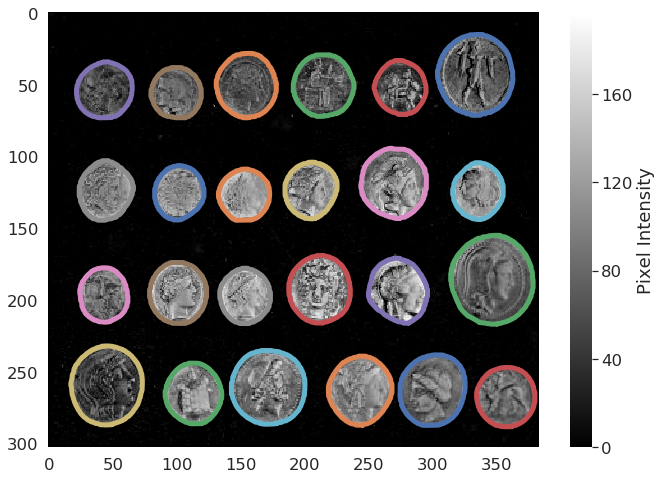

In [13]:
# Find contours that distinguish values below `threshold` from values above `threshold`
threshold = 20
contours = measure.find_contours(coins_cleaner, threshold)

# Show the image
plot_image(coins_clean)

# Show all contours found (one color for each contour)
for n, contour in enumerate(contours):
    plt.plot(contour[:, 1], contour[:, 0], linewidth=5)

# More at http://scikit-image.org/docs/stable/auto_examples/index.html

## Extra math (for those so inclined)

In [14]:
# Suppose we have a noisier version of the same coins image.  
# Here I have added Gaussian random values with a standard deviation of 10 to every pixel
coins_noisy = coins_raw + 10*np.random.randn(*coins_raw.shape)

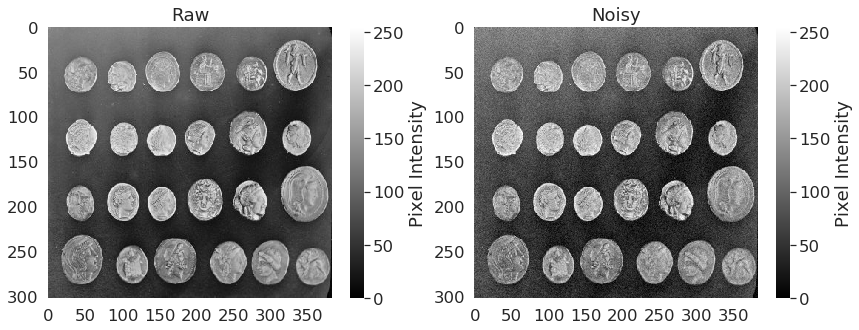

In [15]:
fig, ax = plt.subplots(1,2, figsize=(14,5))
plot_image(coins_raw, title='Raw', ax=ax[0], vmin=0, vmax=255);
plot_image(coins_noisy, title='Noisy', ax=ax[1], vmin=0, vmax=255);

In [16]:
# The singular value decomposition algorithm
from scipy.linalg import svd

### Let's apply the Singular Value Decomposition (SVD).  

### This will decompose the image into 2 matrices, $U$, $S$, and $V$ ($V^T$ is the transpose of $V$), where $U x S x V^T = X$ is a decomposition of a matrix $X$, in this case the raw coins image.  The matrices $U$ and $V$ describe what is happening in the horizontal and vertical directions in the image, which then interact through $S$.  $S$ is a diagonal matrix of so-called singular values, which are like eigenvalues.  $s$ is just that diagonal.  

In [17]:
# We do the singular value decomposition
U, s, V_T = svd(coins_raw, full_matrices=False)

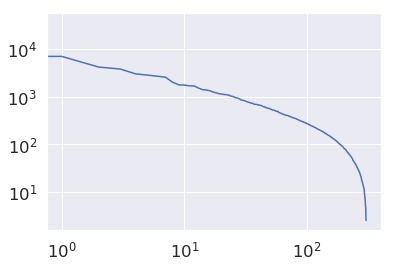

In [18]:
# If we plot these singular values, we see that they fall off significantly near the end
# This suggest that those last few may may not matter.  
plt.plot(s);
plt.xscale('log')
plt.yscale('log')

In [19]:
# The ones that are close to zero may just noise in the image.  
# If we set them to zero, we might be able to eliminate that noise.  
s[150:] = 0

In [20]:
# Now we reconsruct the image by combining the U and V matrices with the new S matrix 
# that has all but the first few singular values set to 0.  
coins_denoised = np.matmul(np.matmul(U, np.diag(s)), V_T)

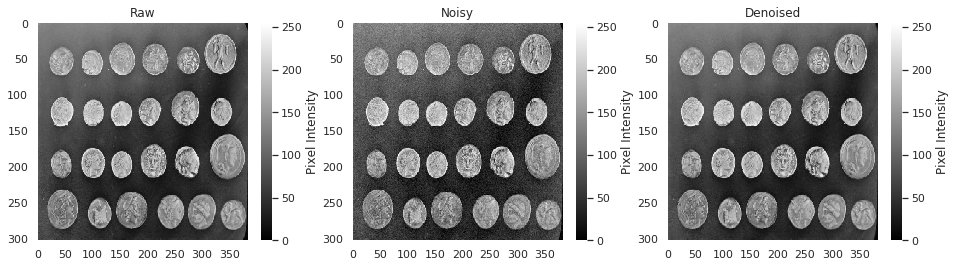

In [22]:
sns.set(font_scale=1.0)
fig, ax = plt.subplots(1,3, figsize=(16,4))
plot_image(coins_raw, title='Raw', ax=ax[0], vmin=0, vmax=255)
plot_image(coins_noisy, title='Noisy', ax=ax[1], vmin=0, vmax=255)
plot_image(coins_denoised, title='Denoised', ax=ax[2], vmin=0, vmax=255);

### This may seem like the kind of result you could obtain by just smoothing, but generally it doesn't work that way.  Smoothing smooths the signal along with the noise.  Zeroing components of the image that correspond to low singular values is a way of isolating the noise, i.e. the non-structured parts of the image, for elimination.